# For Image

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import time
from math import log10, sqrt 

import cv2

import imageio
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

2021-08-09 20:33:18.483690: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


numpy version : 1.21.0
tensorflow version : 2.5.0


### Prepareing Data

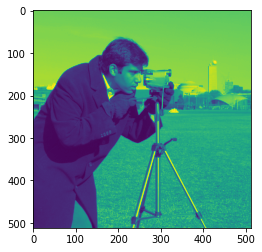

In [2]:
Image = skimage.data.camera()
#Image = plt.imread("8.png")
#Image = plt.imread("CT.jpg") / 255.
plt.imshow(Image)

In [3]:
#def rgb2gray(rgb):
#    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
#  
#Image = rgb2gray(Image)   

In [4]:
# for "1.jpg" image
#Image = plt.imread("1.jpg")
#c = [Image.shape[0]//2, Image.shape[1]//2]
#r = 256
#Image = Image[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
#Image = Image[::2,::2] / 255.
#plt.imshow(Image)

In [5]:
Image = Image.astype(np.float32)
#Image = Image.astype(np.float32)[:256, :256, :]
#Image = Image.astype(np.float32)[:512, :512, :]

In [6]:
Image = Image / 255

In [7]:
# Image = cv2.resize(Image, (256,256), interpolation = cv2.INTER_CUBIC)

In [8]:
def make_coordiante(shape, min_r, max_r):
    x_coordinates = np.linspace(min_r, max_r, shape[0])
    y_coordinates = np.linspace(min_r, max_r, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [9]:
Coordinates = make_coordiante(Image.shape, -1, +1)

In [10]:
RGB_values = Image.flatten()
#RGB_values = np.array([Image[:,:,color].flatten() for color in range(3)]).T
RGB_values.shape


(262144,)

In [11]:
n_fourier_features = 10
scale = 10

B = np.random.randn(2, n_fourier_features)
B = scale * B

Coordinates = Coordinates @ B
Coordinates = np.concatenate([np.cos(2 * math.pi * Coordinates), np.sin(2 * math.pi * Coordinates)], axis=-1)
Coordinates.shape

(262144, 20)

In [12]:
## for Test tile input
#Coordinates = np.tile(Coordinates, (1, 128))

In [13]:
#RGB_mean = RGB_values.mean(axis=0)
#RGB_std = RGB_values.std(axis=0)

#RGB_values = (RGB_values - RGB_mean) / (RGB_std)

### Build Model

#### RBF Layer

In [14]:
class RBFLayer(tf.keras.layers.Layer):
    '''Transforms incoming data using a given radial basis function.
        - Input: (1, N, in_features) where N is an arbitrary batch size
        - Output: (1, N, out_features) where N is an arbitrary batch size'''

    def __init__(self, in_features, out_features):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features



    def build(self, input_shape):
        self.centres = self.add_weight(
            name='centres',
            shape=(self.out_features, self.in_features),
            initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
            trainable=True)
        
        self.sigmas = self.add_weight(
            name='sigmas',
            shape=(self.out_features,),
            initializer=tf.keras.initializers.Constant(10),
            trainable=True)
        

        #self.freq = self.add_weight(
        #    name='freq',
        #    shape=(1, self.out_features),
        #    initializer=tf.keras.initializers.Constant(np.pi),
        #    trainable=True)
        super(RBFLayer, self).build(input_shape)


    def call(self, input):
        size = (input.shape[0], self.out_features, self.in_features)  

        x = tf.expand_dims(input, axis=1)
        x = tf.tile(x, (1, self.out_features, 1))

        c = tf.expand_dims(self.centres, axis=0)
        c = tf.tile(c, (input.shape[0], 1, 1))

        distances = tf.reduce_sum((x - c) ** 2, axis=-1) * tf.expand_dims(self.sigmas, axis=0)

        return self.gaussian(distances)
      
    def gaussian(self, alpha):
        phi = tf.exp(-1 * alpha ** 2)
        return phi

#### Sine Layer

In [15]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        #after_activation = befor_activation
        return after_activation

In [16]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        #after_activation = befor_activation
        return after_activation

#### Parametric

In [17]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    

    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
            
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
        
        #else:
        #    return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit() * self.omega_0),
        #                                               maxval= 1 / (self.cal_limit() * self.omega_0))
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [18]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [19]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    

    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
            
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
        
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a2 = self.add_weight(
            name='a2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/20.),
            trainable=True)
        self.w2 = self.add_weight(
            name='w2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift2 = self.add_weight(
            name='shift2',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a3 = self.add_weight(
            name='a3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(0.),
            trainable=True)
        self.w3 = self.add_weight(
            name='w3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift3 = self.add_weight(
            name='shift3',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a4 = self.add_weight(
            name='a4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(0.),
            trainable=True)
        self.w4 = self.add_weight(
            name='w4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift4 = self.add_weight(
            name='shift4',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a5 = self.add_weight(
            name='a5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/30.),
            trainable=True)
        self.w5 = self.add_weight(
            name='w5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift5 = self.add_weight(
            name='shift5',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        

        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1) + \
                           self.a2 * tf.sin(self.w2 * self.omega_0 * befor_activation + self.shift2) + \
                           self.a3 * tf.cos(self.w3 * self.omega_0 * befor_activation + self.shift3) + \
                           self.a4 * tf.sin(self.w4 * self.omega_0 * befor_activation + self.shift4) + \
                           self.a5 * tf.cos(self.w5 * self.omega_0 * befor_activation + self.shift5)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

#### SIREN

In [20]:
class Siren(tf.keras.Model):
    def __init__(self, in_features,
                    units,
                    out_features,
                    outermost_linear=True,
                    first_omega_0=30.,
                    hidden_omega_0=30.):
        super(Siren, self).__init__()
        self.in_features = in_features
        self.units = units
        self.out_features = out_features
        self.outermost_linear = outermost_linear
        self.first_omega_0 = first_omega_0
        self.hidden_omega_0 = hidden_omega_0


        self.net = []

        self.net.append(SineLayer(self.in_features,
                                  self.units[0],
                                  is_first=True,
                                  omega_0=self.first_omega_0))

        for counter in range(1, len(units)):
            self.net.append(SineLayer(self.units[counter-1],
                                      self.units[counter], 
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))

        if self.outermost_linear:
            self.net.append(tf.keras.layers.Dense(self.out_features,
                                                  kernel_initializer=self.init_weights()))
        else:
            self.net.append(SineLayer(self.units[counter],
                                      self.out_features,
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))


    def init_weights(self):
        return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.units[-1]) / self.hidden_omega_0,
                                                   maxval= np.sqrt(6. / self.units[-1]) / self.hidden_omega_0)



    def call(self, input_tensor):
        x = input_tensor
        for layer in self.net:
            x = layer(x)
        
        return x

In [21]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [22]:
tf.keras.backend.clear_session()




step_show = 1
batch_size = 512 * 512

if len(Image.shape) == 3:
   output_channel = 3
else:
   output_channel = 1


n_fourier_features = 10
scale = 10

B = np.random.randn(2, n_fourier_features)
B = scale * B


loss_fn = tf.keras.losses.MeanSquaredError()
class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self, image_shape, min_r, max_r,  is_fourier=False):
        super(CustomSaver, self).__init__()
        self.Image = Image
        self.image_shape = self.Image.shape

        self.data = make_coordiante(self.image_shape, min_r, max_r)
        if is_fourier:
          self.data = self.data @ B
          self.data = np.concatenate([np.cos(2 * math.pi * self.data), np.sin(2 * math.pi * self.data)], axis=-1)
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        else:
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        self.images = []
    def on_epoch_end(self, epoch, logs={}):
        if epoch % step_show == 0:
           self.images.append(self.model.predict(self.data).reshape(self.image_shape))
           print(f"Epoch {epoch} : loss {loss_fn(self.images[-1], self.Image)}")

save_result_siren = CustomSaver(Image, -1, +1)
save_result_param = CustomSaver(Image, -1, +1)
save_result_relu = CustomSaver(Image, 0, +1)
save_result_fourier = CustomSaver(Image, 0, +1, is_fourier=True)

2021-08-09 20:33:29.087419: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-09 20:33:29.110367: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-09 20:33:29.110387: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Hawk
2021-08-09 20:33:29.110392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Hawk
2021-08-09 20:33:29.110457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.42.1
2021-08-09 20:33:29.110473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.42.1
2021-08-09 20:33:29.110476: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.42.1
2021-08-09 20:33:29.110748: I tensorflow/core/platform/cpu_feature_guard.c

In [23]:
omega_0 = 30
hidden_units = 256

hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/omega_0, maxval=np.sqrt(6/hidden_units)/omega_0)

In [24]:
## SIREN Model
X = tf.keras.layers.Input(shape=(2,))
x1 = SineLayer(2, hidden_units, is_first=True, omega_0=30)(X)
x2 = SineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = SineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = SineLayer(hidden_units, hidden_units, is_first=False)(x3)

#x = tf.keras.layers.Add()([x1, x2, x3, x4])
x = x4

Y = tf.keras.layers.Dense(output_channel, kernel_initializer=hidden_initializers)(x)

siren_model = tf.keras.models.Model(X, Y)

In [25]:
## Parametric Model
X = tf.keras.layers.Input(shape=(2,))
x1 = ParaSineLayer(2, hidden_units, is_first=True, omega_0=30)(X)
x2 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x3)

#x = tf.keras.layers.Add()([x1, x2, x3, x4])
x = x4

Y = tf.keras.layers.Dense(output_channel, kernel_initializer=hidden_initializers)(x)

parametric_model = tf.keras.models.Model(X, Y)

In [26]:
## Fourier Model
X = tf.keras.layers.Input(shape=(2 * n_fourier_features,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

#x = tf.keras.layers.Add()([x1, x2, x3, x4])
x = x4

Y = tf.keras.layers.Dense(output_channel, activation="sigmoid")(x)

fourier_model = tf.keras.models.Model(X, Y)

In [27]:
## Relu Model
X = tf.keras.layers.Input(shape=(2,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

#x = tf.keras.layers.Add()([x1, x2, x3, x4])
x = x4

Y = tf.keras.layers.Dense(output_channel, activation="sigmoid")(x)

relu_model = tf.keras.models.Model(X, Y)

In [28]:
siren_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sine_layer (SineLayer)       (None, 256)               768       
_________________________________________________________________
sine_layer_1 (SineLayer)     (None, 256)               65792     
_________________________________________________________________
sine_layer_2 (SineLayer)     (None, 256)               65792     
_________________________________________________________________
sine_layer_3 (SineLayer)     (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 198,401
Trainable params: 198,401
Non-trainable params: 0
_______________________________________________________

In [29]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    if epoch % 100 == 0:
        lr = lr * tf.math.exp(-0.05)
    return lr
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
    dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))
    dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)



In [31]:
dataset

<BatchDataset shapes: ((None, 20), (None,)), types: (tf.float64, tf.float32)>

In [32]:
models = [parametric_model,
          siren_model,
          relu_model,
          fourier_model
          ]

callbacks = [save_result_param,
             save_result_siren,
             save_result_relu,
             save_result_fourier
             ]

model_name = [
              "Parametric",
              "Siren",
              "Relu",
              "Fourier Feature"    
]

with_fourier = [False,
                False,
                False,
                True]

with_relu = [False,
             False,
             True,
             True]

models = [siren_model]




History = []

epochs = 10
for counter in range(len(models)):
    if with_relu[counter]:
       Coordinates = make_coordiante(Image.shape, 0, 1)
    else:
       Coordinates = make_coordiante(Image.shape, -1, 1)

    
    if with_fourier[counter]:
       Coordinates = Coordinates @ B
       Coordinates = np.concatenate([np.cos(2 * math.pi * Coordinates), np.sin(2 * math.pi * Coordinates)], axis=-1)
    
    dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values)).batch(batch_size)
    # dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)

    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss = tf.keras.losses.MeanSquaredError() 

    models[counter].compile(optimizer=optimizer, loss=loss)

    print(20*"*", model_name[counter], 20*"*")
    #history = models[counter].fit(dataset, epochs=epochs, callbacks=[callback, callbacks[counter]], verbose=0)
    history = models[counter].fit(dataset, epochs=epochs, callbacks=[callbacks[counter]], verbose=0)
    History.append(history.history['loss'])

******************** Parametric ********************


2021-08-09 20:33:36.716829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-09 20:33:36.734867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Epoch 0 : loss 0.31000855565071106


Epoch 1 : loss 0.2914707362651825


Epoch 2 : loss 0.2814968526363373


Epoch 3 : loss 0.2772783935070038


Epoch 4 : loss 0.2701371908187866


Epoch 5 : loss 0.2593405246734619


Epoch 6 : loss 0.2467900514602661


Epoch 7 : loss 0.23055720329284668


Epoch 8 : loss 0.21043658256530762


Epoch 9 : loss 0.18434098362922668


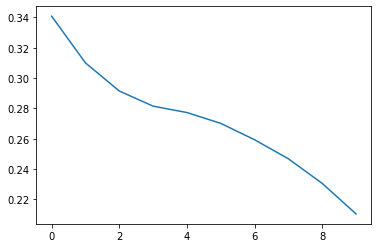

In [33]:
plt.plot(np.stack(History).T)

In [34]:
callbacks = [
             save_result_relu,
             save_result_fourier,
             save_result_siren,
             save_result_param   
]

In [35]:
Video = []
#model_psnr = []
for save_result in callbacks:
  Video.append(np.stack(save_result.images))
  #psnr_buff = []
  #for image in save_result.images:
  #    psnr_buff.append(PSNR(Image, image))
  #model_psnr.append(psnr_buff)

#model_psnr = np.stack(model_psnr)
Video = np.concatenate(Video, axis=2)


model_psnr = 20 * np.log10(1.0 / np.sqrt(np.stack(History).T)).T

ValueError: need at least one array to stack

In [36]:
if output_channel == 3: 
   images_gt = np.tile(np.expand_dims(Image, axis=0), (int(epochs / step_show), 1, 1, 1))
else:
   images_gt = np.tile(np.expand_dims(Image, axis=0), (int(epochs / step_show), 1, 1))
Video = np.concatenate([images_gt, Video], axis=2)   
Video = (255 * np.clip(Video, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, Video, fps=3)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

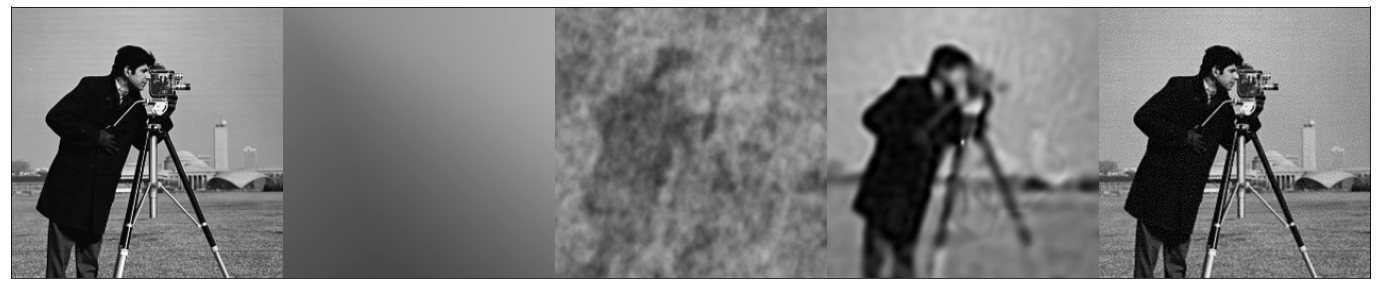

In [ ]:
text_font = {'fontname':'Arial', 'size':'20'}

plt.figure(figsize=(25, 5))
plt.imshow(Video[7], cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.text(1 * 256 - 100, -20, 'Original', **text_font)
#plt.text(3 * 256 - 50 , -20, 'Relu', **text_font)
#plt.text(5 * 256 - 120, -20, 'Fourier Features', **text_font)
#plt.text(7 * 256 - 50 , -20, 'Siren', **text_font)
#plt.text(9 * 256 - 140, -20, 'Parametric(Ours)', **text_font)

plt.savefig('Compresion_on_Epoch20.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

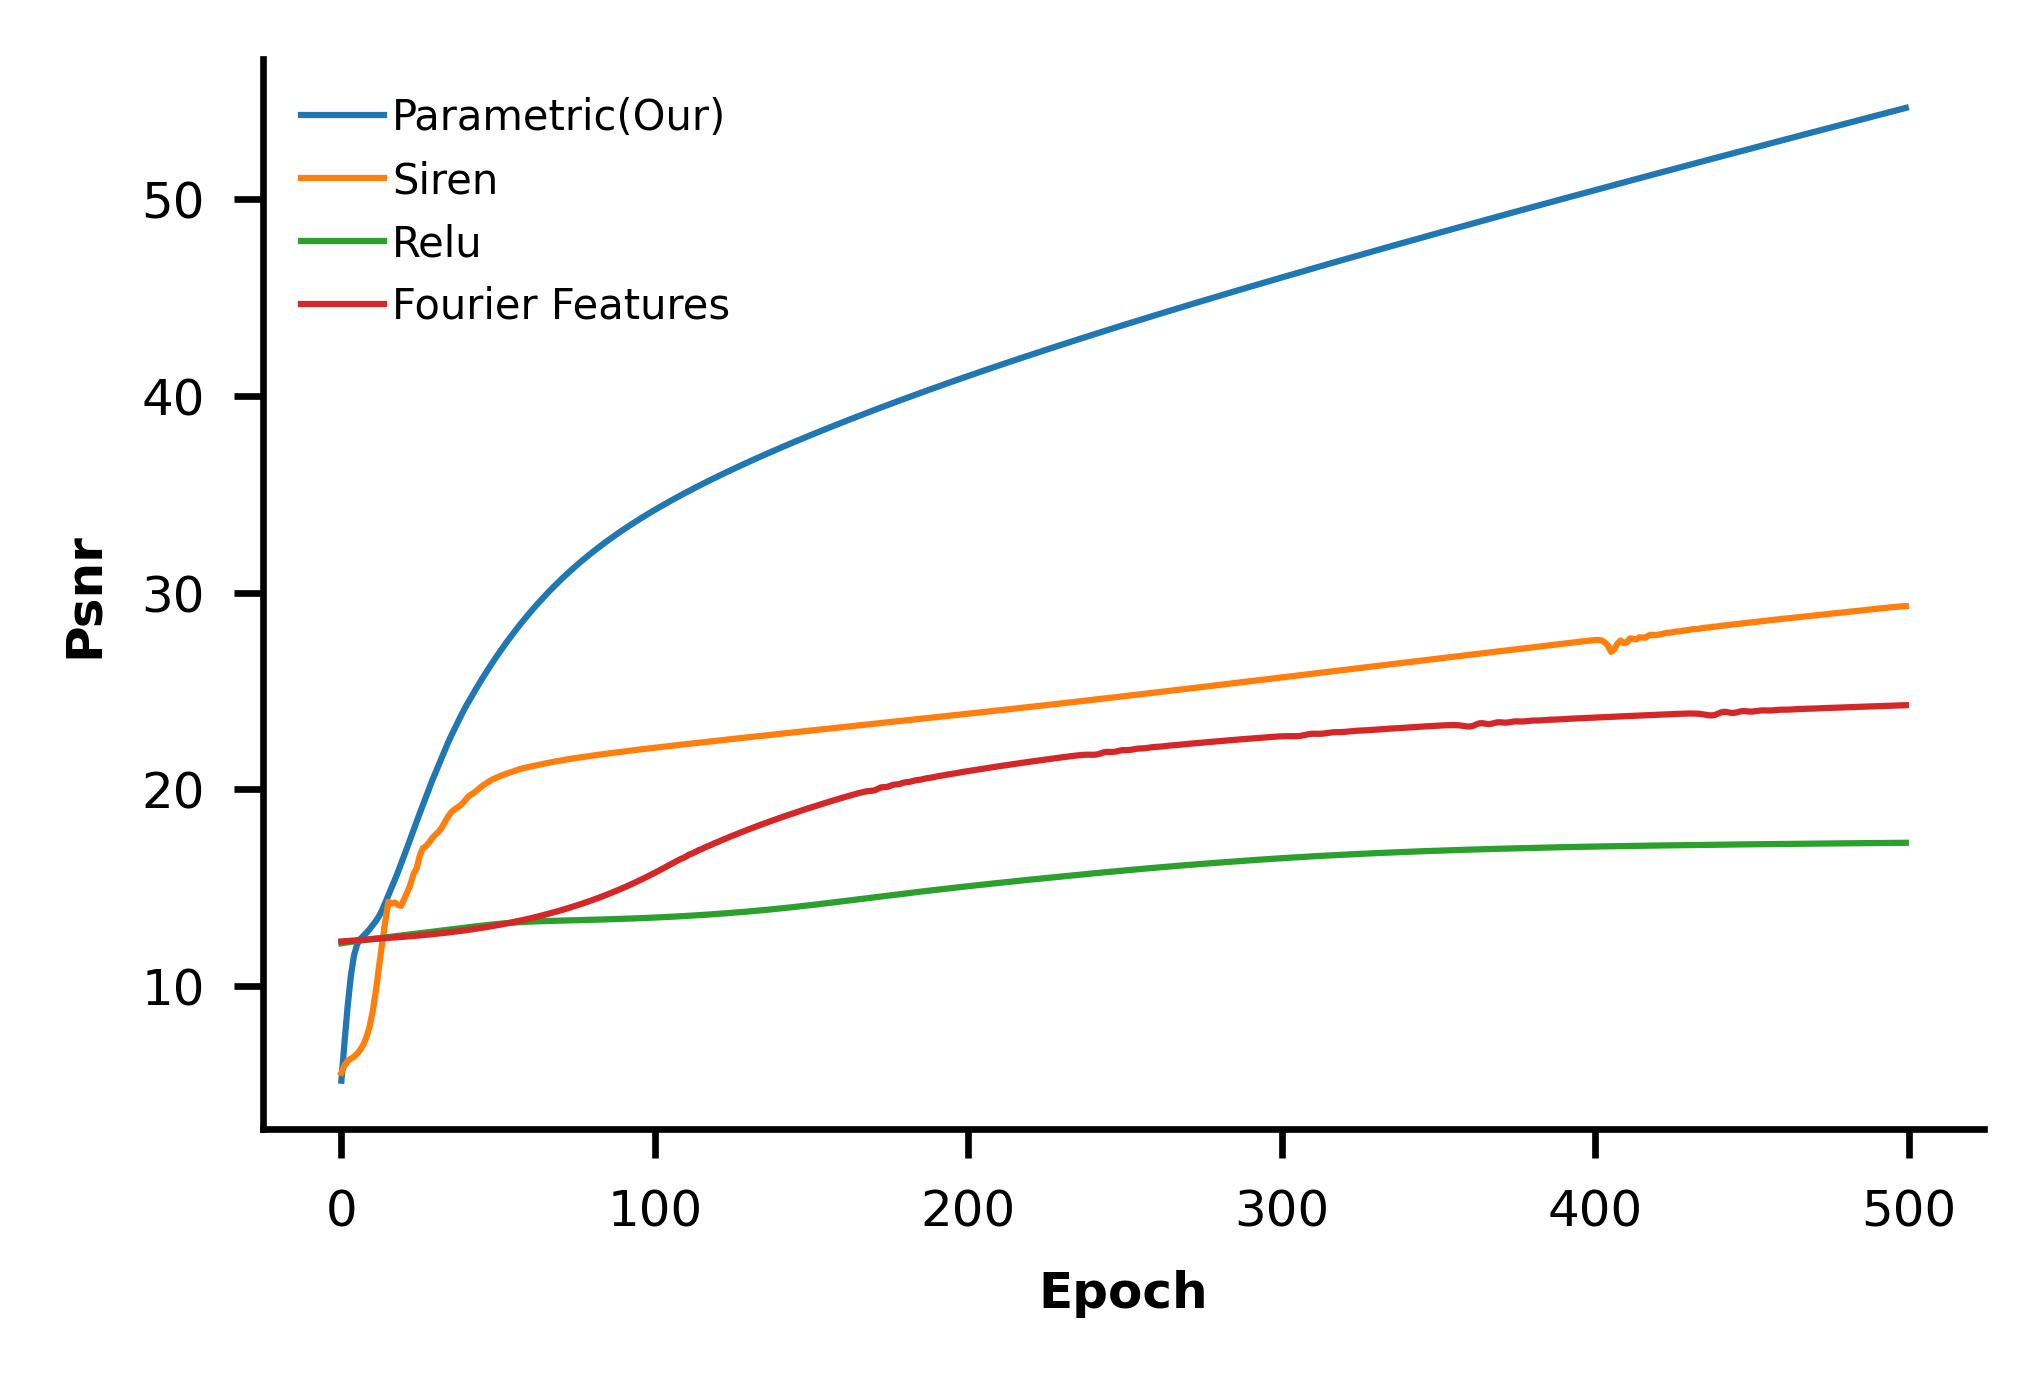

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import matplotlib.font_manager as font_manager


def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)



mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['ps.fonttype'] = 3
mpl.rcParams['font.family'] = 'Arial'


mpl.rcParams['axes.titlesize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.labelweight'] = "bold"


mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6


mpl.rcParams['legend.fontsize'] = 5



fig = plt.figure(figsize=cm2inch(9.4,6), dpi=600)
ax=plt.axes()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


legend_font = font_manager.FontProperties(family='Arial')


plt.plot(model_psnr.T, linewidth=0.75)



#plt.ylim([0, 50])

#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.yaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(2))

plt.xlabel('Epoch')
plt.ylabel('Psnr')
ax.legend(['Parametric(Our)', 'Siren', 'Relu', 'Fourier Features'],
          loc='upper left',
          bbox_to_anchor=(0,1),
          handletextpad=0.2,
          frameon=False)


plt.savefig('PSNR_Compresion.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)